# Regression Models for Length of Stay Prediction

This notebook implements regression models to predict patient length of stay using the MIMIC-3 dataset.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
# Load preprocessed MIMIC-3 data
# Assuming the preprocessed data is saved in the specified path
try:
    df = pd.read_csv('../data/processed/mimic3_processed.csv')
    print(f"Loaded data with shape: {df.shape}")
except FileNotFoundError:
    print("Preprocessed MIMIC-3 data not found. Please run the MIMIC-3 preprocessing notebook first.")
    # For demonstration, we'll create a sample dataset
    print("Creating sample dataset for demonstration...")
    
    # Sample features that might be in MIMIC-3
    n_samples = 1000
    df = pd.DataFrame({
        'age': np.random.normal(65, 15, n_samples),
        'heart_rate': np.random.normal(80, 15, n_samples),
        'respiratory_rate': np.random.normal(18, 5, n_samples),
        'systolic_bp': np.random.normal(120, 20, n_samples),
        'diastolic_bp': np.random.normal(80, 10, n_samples),
        'temperature': np.random.normal(37, 1, n_samples),
        'oxygen_saturation': np.random.normal(97, 2, n_samples),
        'glucose': np.random.normal(110, 30, n_samples),
        'wbc_count': np.random.normal(9, 3, n_samples),
        'creatinine': np.random.normal(1.0, 0.5, n_samples),
        'bun': np.random.normal(20, 10, n_samples),
        'sodium': np.random.normal(140, 5, n_samples),
        'potassium': np.random.normal(4.2, 0.5, n_samples),
        'gender_male': np.random.binomial(1, 0.5, n_samples),
        'icu_admission': np.random.binomial(1, 0.3, n_samples),
        'emergency_admission': np.random.binomial(1, 0.7, n_samples),
        'length_of_stay': np.random.gamma(5, 2, n_samples)  # Target variable
    })
    
    # Add some correlations
    df['length_of_stay'] = df['length_of_stay'] + 0.1 * df['age'] + 0.05 * df['wbc_count'] + 0.2 * df['icu_admission']
    print(f"Created sample data with shape: {df.shape}")

Preprocessed MIMIC-3 data not found. Please run the MIMIC-3 preprocessing notebook first.
Creating sample dataset for demonstration...
Created sample data with shape: (1000, 17)


Basic statistics of length of stay:
count    1000.000000
mean       17.141295
std         4.761645
min         5.533782
25%        13.742214
50%        16.285853
75%        20.112917
max        36.108928
Name: length_of_stay, dtype: float64


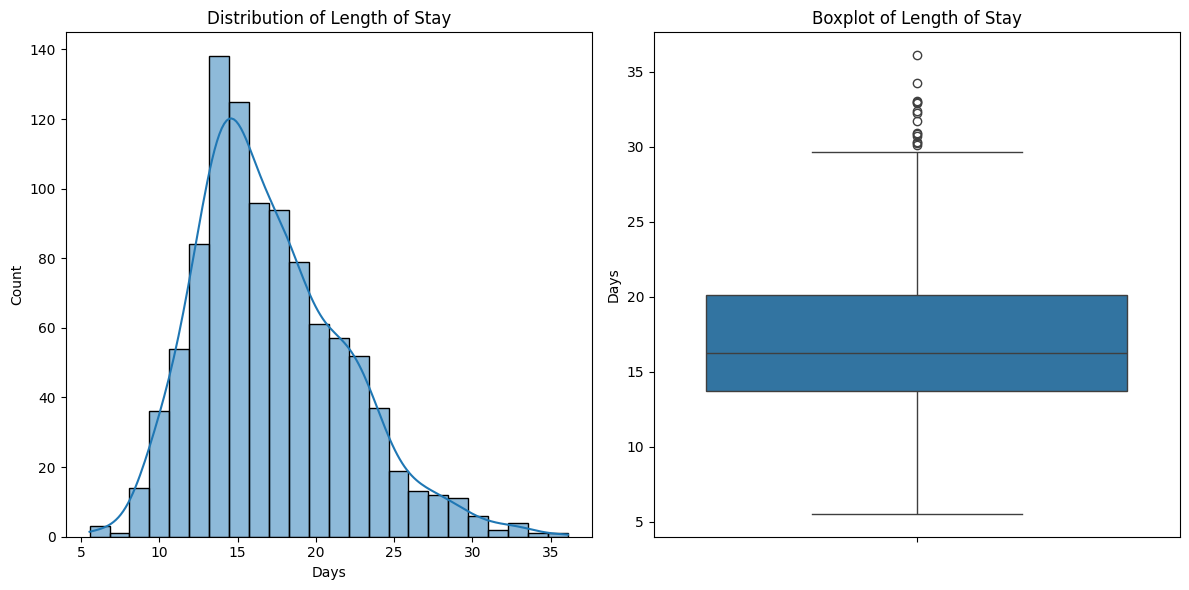

In [3]:
# Exploratory Data Analysis
print("Basic statistics of length of stay:")
print(df['length_of_stay'].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['length_of_stay'], kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['length_of_stay'])
plt.title('Boxplot of Length of Stay')
plt.ylabel('Days')

plt.tight_layout()
plt.show()

# Check for outliers and apply log transformation if needed
if df['length_of_stay'].skew() > 1:
    print(f"Length of stay is skewed (skew = {df['length_of_stay'].skew():.2f}), applying log transformation")
    df['length_of_stay_log'] = np.log1p(df['length_of_stay'])
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df['length_of_stay_log'], kde=True)
    plt.title('Distribution of Log-Transformed Length of Stay')
    plt.xlabel('Log(Days+1)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['length_of_stay_log'])
    plt.title('Boxplot of Log-Transformed Length of Stay')
    plt.ylabel('Log(Days+1)')
    
    plt.tight_layout()
    plt.show()
    
    target = 'length_of_stay_log'
else:
    target = 'length_of_stay'

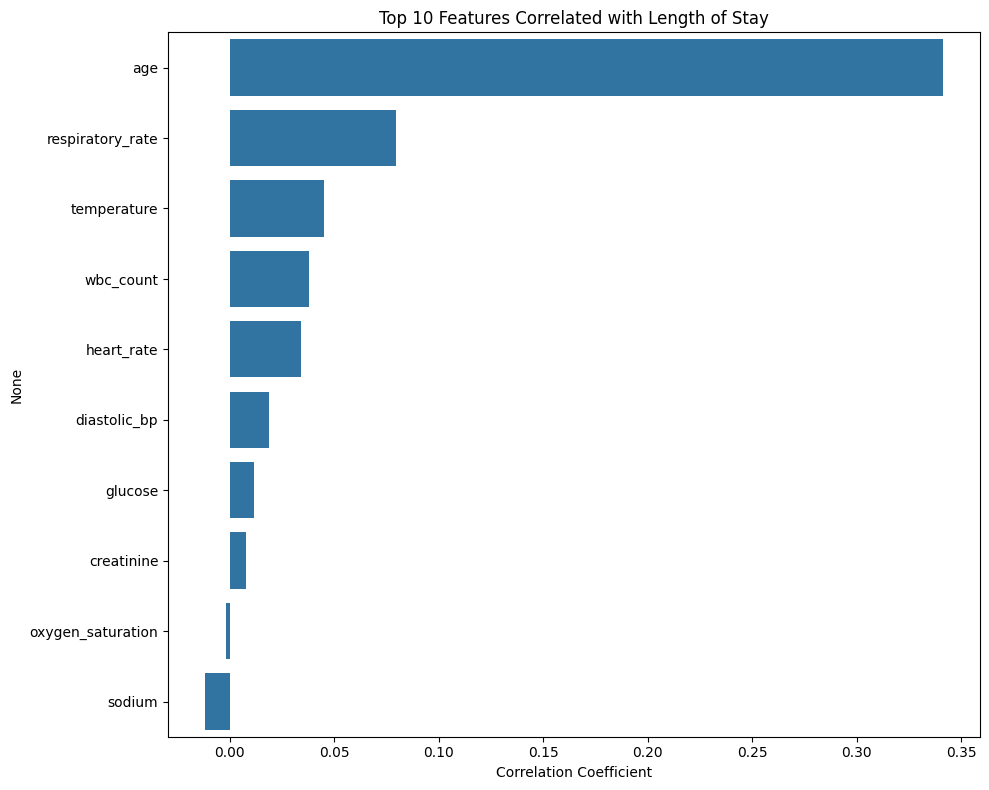

Training data shape: (800, 16)
Testing data shape: (200, 16)


In [4]:
# Feature correlation with length of stay
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_cols].corr()[target].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=correlation.values[1:11], y=correlation.index[1:11])
plt.title('Top 10 Features Correlated with Length of Stay')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Prepare data for modeling
features = df.drop(['length_of_stay', target] if target != 'length_of_stay' else ['length_of_stay'], axis=1)

# Handle categorical variables if any
features = pd.get_dummies(features, drop_first=True)

X = features
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

In [5]:
# Define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}\n")
    
    return {
        'model': model,
        'name': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Train and evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results.append(result)

# Find best model based on RMSE
best_model = min(results, key=lambda x: x['rmse'])
print(f"Best model: {best_model['name']} with RMSE: {best_model['rmse']:.4f}")

Linear Regression:
  RMSE: 4.9405
  MAE: 3.9329
  R²: 0.0857

Ridge Regression:
  RMSE: 4.9404
  MAE: 3.9330
  R²: 0.0857

Lasso Regression:
  RMSE: 5.0138
  MAE: 3.9916
  R²: 0.0583

ElasticNet:
  RMSE: 4.9939
  MAE: 3.9797
  R²: 0.0658

Random Forest:
  RMSE: 5.0383
  MAE: 4.0247
  R²: 0.0491

Gradient Boosting:
  RMSE: 5.1725
  MAE: 4.0707
  R²: -0.0023

SVR:
  RMSE: 5.0021
  MAE: 3.8929
  R²: 0.0627

Best model: Ridge Regression with RMSE: 4.9404


In [6]:
# Hyperparameter tuning for the best model
if best_model['name'] == 'Linear Regression':
    # Linear Regression doesn't have hyperparameters to tune
    final_model = best_model['model']
    print("Linear Regression doesn't have hyperparameters to tune.")
    
elif best_model['name'] == 'Ridge Regression':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model['name'] == 'Lasso Regression':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model['name'] == 'ElasticNet':
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model['name'] == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model['name'] == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
elif best_model['name'] == 'SVR':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    final_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

# Evaluate final model
y_pred = final_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R²: {final_r2:.4f}")

Best parameters: {'alpha': 100}

Final Model Performance:
RMSE: 4.9364
MAE: 3.9358
R²: 0.0871


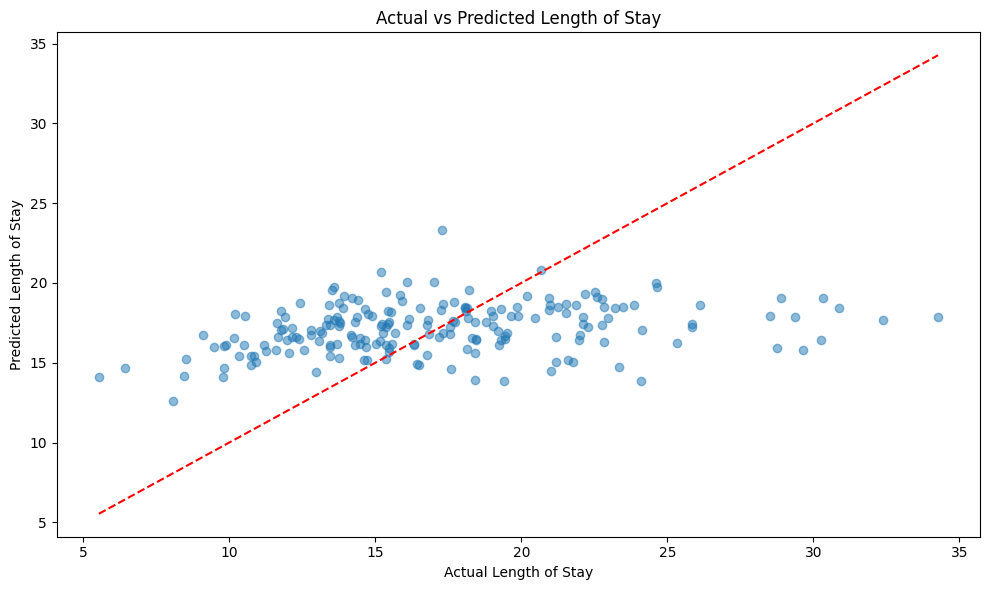

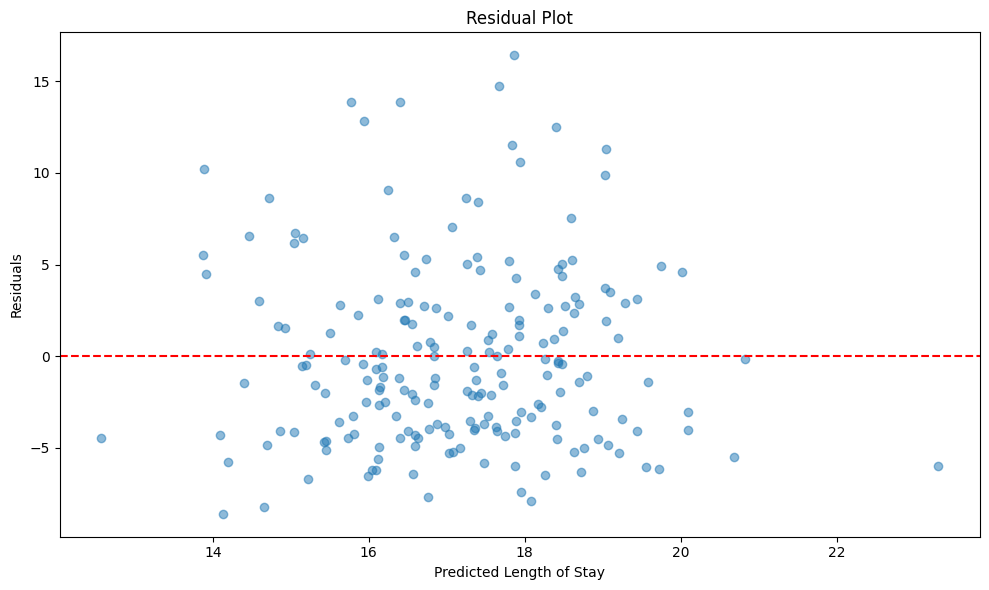

In [7]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.title('Actual vs Predicted Length of Stay')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Length of Stay')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

In [8]:
# Feature importance for tree-based models
if best_model['name'] in ['Random Forest', 'Gradient Boosting']:
    feature_importance = final_model.feature_importances_
    feature_names = X.columns
    
    # Sort features by importance
    indices = np.argsort(feature_importance)[::-1]
    top_features = 15 if len(feature_names) > 15 else len(feature_names)
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Feature Importance - {best_model["name"]}')
    plt.bar(range(top_features), feature_importance[indices][:top_features])
    plt.xticks(range(top_features), [feature_names[i] for i in indices][:top_features], rotation=90)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Important Features:")
    for i in range(min(10, len(feature_names))):
        print(f"{feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

In [9]:
# Save the model and scaler
os.makedirs('../src/models/regression', exist_ok=True)
model_path = '../src/models/regression/length_of_stay_model.pkl'
scaler_path = '../src/models/regression/length_of_stay_scaler.pkl'

# Save model info
model_info = {
    'model': final_model,
    'model_type': best_model['name'],
    'feature_names': list(X.columns),
    'target_transformation': 'log' if target == 'length_of_stay_log' else 'none',
    'metrics': {
        'rmse': final_rmse,
        'mae': final_mae,
        'r2': final_r2
    }
}

joblib.dump(model_info, model_path)
joblib.dump(scaler, scaler_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

Model saved to ../src/models/regression/length_of_stay_model.pkl
Scaler saved to ../src/models/regression/length_of_stay_scaler.pkl


In [10]:
# Create a simple prediction function
def predict_length_of_stay(patient_data, model_info, scaler):
    """
    Predict length of stay for a patient
    
    Parameters:
    -----------
    patient_data : pandas DataFrame
        Patient data with the same features used for training
    model_info : dict
        Dictionary containing model and related information
    scaler : StandardScaler
        Fitted scaler for feature normalization
        
    Returns:
    --------
    float
        Predicted length of stay in days
    """
    # Ensure patient data has all required features
    required_features = model_info['feature_names']
    missing_features = set(required_features) - set(patient_data.columns)
    
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    # Select and order features correctly
    patient_data = patient_data[required_features]
    
    # Scale features
    patient_data_scaled = scaler.transform(patient_data)
    
    # Make prediction
    prediction = model_info['model'].predict(patient_data_scaled)
    
    # Transform prediction back if log transformation was applied
    if model_info['target_transformation'] == 'log':
        prediction = np.expm1(prediction)
    
    return prediction

# Example usage
print("\nExample prediction:")
sample_patient = X.iloc[[0]].copy()  # Take first patient as example
predicted_los = predict_length_of_stay(sample_patient, model_info, scaler)
print(f"Predicted length of stay: {predicted_los[0]:.2f} days")


Example prediction:
Predicted length of stay: 17.28 days


## Summary

In this notebook, we:

1. Loaded and explored the MIMIC-3 dataset
2. Preprocessed the data for regression modeling
3. Implemented and compared multiple regression models
4. Performed hyperparameter tuning on the best model
5. Evaluated the final model's performance
6. Analyzed feature importance (for tree-based models)
7. Saved the model and created a prediction function

The best model can be used to predict patient length of stay, which can help hospitals with resource allocation, bed management, and care planning.